## Script to produce plots of the profiling output

Just run all the cells in this notebook.

The script looks for profiling logs with filename in the format `baseline_<commitID>_<hostID>.txt` in the `TIMING_BASELINES_DIR` directory.

In [134]:
TIMING_BASELINES_DIR = "baselines"

In [135]:
import os
from glob import glob
import numpy as np
from astropy.io import ascii
from astropy.table import Column
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.cm import get_cmap
%matplotlib inline
plt.style.use('ggplot')

mpl.rcParams['font.size'] = 14
mpl.rcParams['ytick.right'] = False
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6


#          : False  # draw ticks on the right side

In [271]:
def autolabel(ax, rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%dx' % (height),
                ha='center', va='bottom')



In [272]:
def bracket(ax, text, xmin, xmax, y, fontsize, color, lw, hw=None):
    
    if not hw:
        hw = len(text)/20.
    xcenter = 0.5*(xmin+xmax)
    ax.annotate(text, (xcenter, y), color=color, fontsize=fontsize, ha='center', va='center')
    ax.annotate("", xy=(xmax, y), xycoords='data',
                    xytext=(xcenter+hw, y), textcoords='data',
                    arrowprops=dict(arrowstyle="-", connectionstyle="bar, fraction=0", color=color, lw=lw))
    ax.annotate("", xy=(xmin, y), xycoords='data',
                    xytext=(xcenter-hw, y), textcoords='data',
                    arrowprops=dict(arrowstyle="-", connectionstyle="bar, fraction=0.", color=color, lw=lw))


In [298]:
def plot_profiling(filename, plot_prefix='', plot_ext='pdf', baselines=None, 
                   plot_execution_times=False, plot_CPUGPU_speedup=False, plot_GPU_vs_tpb=False):
    print("Reading {}".format(filename))

    tb = ascii.read(filename)
    tb['speedup'] = np.ones(len(tb))
    
    funcname, _, commitID, hostID =os.path.splitext(os.path.basename(filename))[0].split('_')
        
    if plot_prefix == '':
         plot_prefix = funcname
            
    sizes = np.unique(tb['size'])
    
    # compute speedup
    if not baselines:
        baselines = dict()
        for size in sizes:
            # take the serial CPU as the baseline for speed-up computation  
            baselines[size]= tb[np.where((tb['size'] == size) & (tb['OMP'] == 1))]['Tmin'][0]
        
#             tb['speedup'][tb['size'] == size] *= baselines[size]/tb[tb['size'] == size]['Tmin'] 

    for size in sizes:
        tb['speedup'][tb['size'] == size] *= baselines[size]['Tmin']/tb[tb['size'] == size]['Tmin'] 
            
    cpu_rows = np.where(tb['tpb']==0)
    gpu_rows = np.where(tb['tpb']!=0)
    
    tb_CPU = tb[cpu_rows]
    tb_GPU = tb[gpu_rows]

    # Plot 1: CPU Speedup vs OpenMP threads    
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    
    cmap = get_cmap('plasma_r', lut=len(sizes))
    for i, size in enumerate(sizes):
        select_size = tb_CPU['size'] == size
        ax.plot(tb_CPU[select_size]['OMP'], 
                tb_CPU[select_size]['speedup']/tb_CPU[select_size][tb_CPU[select_size]['OMP'] == 1]['speedup'], 
                '.-', ms=16, lw=1.2, label=size,  color=cmap(i))

    ax.set_xticks(tb_CPU[select_size]['OMP'])
    ax.set_xticklabels(tb_CPU[select_size]['OMP'])
    ax.set_xlabel("OpenMP threads")
    ax.set_ylabel("Speedup vs serial version")

    ylim = ax.get_ylim()
    # add a linear scaling line
    ax.plot([1, 12], [1, 12], '--', c='k', zorder=-10)
    ax.set_ylim(0.01, 8.)
    bracket(ax, "Physical cores", 1., 5.9, 0.5, 14, 'k', lw=1.3, hw=1.75)
    bracket(ax, "Hyper Threading", 6.1, 12., 0.5, 14, 'k', lw=1.3, hw=1.9)



    # title
#     ax.text(0.5, 0.98, "sample{}()".format(funcname.title()), 
#             va='top', ha='center', color='k', fontsize=14, transform=ax.transAxes)
    
    ax.set_title("chi2{}()".format(funcname.title()))
                 
    # watermark
    ax.text(1.01, 0.95, "{} @ {}".format(commitID, hostID), rotation=90, 
        va='top', ha='left', color='gray', fontsize=4, transform=ax.transAxes)
        
    ax.legend()
    plt.tight_layout()
    plt.savefig("{}plot_CPU_{}_{}3.{}".format(plot_prefix, commitID, hostID, plot_ext))
    plt.clf()

    
    # Plot 2: GPU Speedup vs threads_per_block
    if plot_GPU_vs_tpb:
        plt.figure(figsize=(6, 6))
        ax = plt.subplot(111)

        for size in sizes:
            select_size = tb_GPU['size'] == size
            ax.plot(tb_GPU[select_size]['tpb'], tb_GPU[select_size]['speedup'], '.-', ms=16, lw=1.2,label=size)

        ax.set_xticks(tb_GPU[select_size]['tpb'])
        ax.set_xticklabels(tb_GPU[select_size]['tpb'])
        ax.set_xlabel("Threads per block")
        ax.set_ylabel("Speedup")

        ylim = ax.get_ylim()
        ax.set_ylim(ylim)

        # watermark
        ax.text(1.01, 0.98, "{} @ {}".format(commitID, hostID), rotation=90, 
                va='top', ha='left', color='gray', fontsize=4, transform=ax.transAxes)

        ax.legend()
        plt.tight_layout()
        plt.savefig("plot_GPU_{}_{}.{}".format(commitID, hostID, plot_ext))
        plt.clf()


    # Plot 3: CPU-GPU Speedup vs matrix size
    if plot_CPUGPU_speedup:
        plt.figure(figsize=(6, 6))
        ax = plt.subplot(111)

        colors = ['#ffc425', '#f37735', '#00aedb', '#00b159', '#d11141', 'k']
        selection_GPU = (tb_GPU['tpb'] == 16) 
        selection_CPU = (tb_CPU['OMP'] == 6) 
        ax.plot(np.log2(tb_GPU[selection_GPU]['size']) ,
                tb_GPU[selection_GPU]['speedup'],
                '.-', c=colors[0], ms=16, lw=1.2,label='GPU')
        ax.plot(np.log2(tb_CPU[selection_CPU]['size']),
                tb_CPU[selection_CPU]['speedup'],
                '.-', c=colors[2], ms=16, lw=1.2,label='CPU')

        ax.set_xticks(np.log2(tb_GPU['size']))
        ax.set_xticklabels(tb_GPU['size'], rotation=45)
        ax.set_ylim(1, 12)
        ax.set_xlabel("Image Size")
        ax.set_ylabel("Speedup")

        # watermark
        ax.text(1.01, 0.98, "{} @ {}".format(commitID, hostID), rotation=90, 
                va='top', ha='left', color='gray', fontsize=4, transform=ax.transAxes)

        ax.legend()
        plt.tight_layout()
        plt.savefig("plot_CPU_GPU_{}_{}.{}".format(commitID, hostID, plot_ext))
        plt.clf()


    # Plot 4: Execution times
    if plot_execution_times:
        plt.figure(figsize=(6, 6))
        ax = plt.subplot(111)

        y_unit = 1.e3 # milliseconds
    #     y_unit = 1 # seconds
        colors = ['#ffc425', '#f37735', '#00aedb', '#00b159', '#d11141', 'k']
        selection_GPU = (tb_GPU['tpb'] == 16) 
        selection_CPU = (tb_CPU['OMP'] == 6) 
        ax.plot(np.log2(tb_GPU[selection_GPU]['size']), 
                tb_GPU[selection_GPU]['Tmin']*y_unit,
                '.-', c=colors[0], ms=16, lw=1.2,label='GPU')
        ax.plot(np.log2(tb_CPU[selection_CPU]['size']), 
                tb_CPU[selection_CPU]['Tmin']*y_unit,
                '.-', c=colors[2], ms=16, lw=1.2,label='CPU')

        ax.set_xticks(np.log2(tb_GPU['size']))
        ax.set_xticklabels(tb_GPU['size'], rotation=45)
        ax.set_xlabel("Image Size")
        ax.set_ylabel("Execution times")

        ax.set_yscale('log')

        # watermark
        ax.text(1.01, 0.98, "{} @ {}".format(commitID, hostID), rotation=90, 
                va='top', ha='left', color='gray', fontsize=4, transform=ax.transAxes)

        ax.legend()
        plt.tight_layout()
        plt.savefig("plot_execution_times_{}_{}.{}".format(commitID, hostID, plot_ext))
        plt.clf()    

        print("Done")


    # Plot 5: histogram Relative Performance
    N = len(sizes)

    ind = np.arange(N)  # the x locations for the groups
    width = 0.23       # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 6))
    
    # nvidia green: '#76b900'
#     colors = {"CPU_serial": '#484848',
#               "CPU_6cores": '#ffc425',
#               "CPU_12cores": '#f47835',
#               "GPU": '#d41243'}
    
    colors = {"CPU_serial": '#03396c',
              "CPU_6cores": '#005b96',
              "CPU_12cores": '#6497b1',
              "GPU": '#d90000'}
    
    
    rects_CPU_serial = ax.bar(ind - width*1.5, tb_CPU[tb_CPU['OMP'] == 1]['speedup'], width, color=colors['CPU_serial'])
    rects_CPU_6cores = ax.bar(ind - width*0.5, tb_CPU[tb_CPU['OMP'] == 6]['speedup'], width, color=colors['CPU_6cores'])
    rects_CPU_12cores = ax.bar(ind + width*0.5, tb_CPU[tb_CPU['OMP'] == 12]['speedup'], width, color=colors['CPU_12cores'])
    rects_GPU = ax.bar(ind + width*1.5, tb_GPU[tb_GPU['tpb'] == 32]['speedup'], width, color=colors['GPU'])

    # add some text for labels, title and axes ticks
    ax.set_xlabel('Image size')
    ax.set_ylabel('Speedup vs Python (numpy, scipy)')
    ax.set_title("chi2{}()".format(funcname.title()))
    ax.set_xticks(ind)
    ax.set_xticklabels([r'{}$^2$'.format(size) for size in sizes])
    ax.set_ylim(-24, ax.get_ylim()[1]*1.25)

    ax.legend((rects_CPU_serial[0], rects_CPU_6cores[0], rects_CPU_12cores[0], rects_GPU[0]), 
              ('CPU serial', 'CPU 6 threads', 'CPU 12 threads', 'GPU'), fontsize=14, 
              frameon=True, loc='upper left')
    
    # watermark
    ax.text(1.005, 0.95, "{} @ {}".format(commitID, hostID), rotation=90, 
        va='top', ha='left', color='gray', fontsize=4, transform=ax.transAxes)
    
    autolabel(ax, rects_CPU_serial)
    autolabel(ax, rects_CPU_6cores)
    autolabel(ax, rects_CPU_12cores)
    autolabel(ax, rects_GPU)
 
    bracket(ax, "ALMA", 0., 5, -8, 13, 'k', lw=1.3)
    bracket(ax, "Jansky VLA", 1, 5, -18, 13, 'k', lw=1.3, hw=0.3)




    
    fig.tight_layout()
    fig.savefig("{}bar_performance_{}_{}.{}".format(plot_prefix, commitID, hostID, plot_ext))

    return tb

Reading baselines/profile_baseline_af77476_calx174.ast.cam.ac.uk.txt


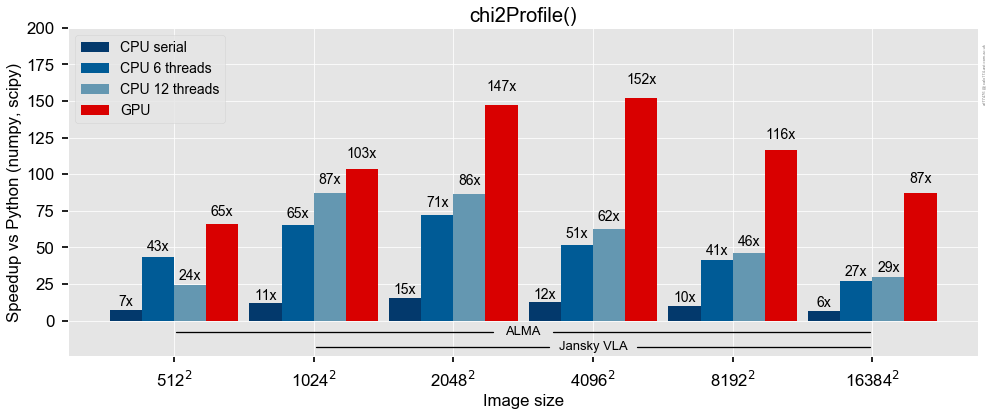

In [299]:
# import baselines as python version
tb_py = ascii.read("baselines/profile_py_baseline_b418740_calx174.ast.cam.ac.uk.txt")

profile_baselines = dict()
for i in range(len(tb_py)):
    profile_baselines[tb_py[i]['size']]={'Tmin':tb_py[i]['Tmin'], 'Tstd':tb_py[i]['Tstd']}
    
# analyze this one
filename = 'baselines/profile_baseline_af77476_calx174.ast.cam.ac.uk.txt'
tb1 = plot_profiling(filename, plot_prefix='profile_', plot_ext='pdf', baselines=profile_baselines)

Reading baselines/image_baseline_af77476_calx174.ast.cam.ac.uk.txt


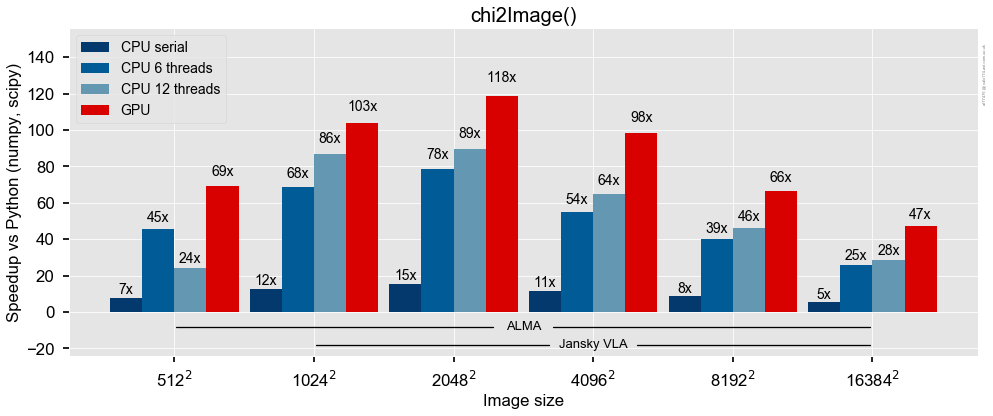

In [300]:
# import baselines as python version
tb_py = ascii.read("baselines/image_py_baseline_b418740_calx174.ast.cam.ac.uk.txt")

image_baselines = dict()
for i in range(len(tb_py)):
    image_baselines[tb_py[i]['size']]={'Tmin':tb_py[i]['Tmin'], 'Tstd':tb_py[i]['Tstd']}
    
# analyze this one
filename = 'baselines/image_baseline_af77476_calx174.ast.cam.ac.uk.txt'
tb1 = plot_profiling(filename, plot_prefix='image_', plot_ext='pdf', baselines=image_baselines)

### Compute typical Image sizes for ALMA and VLA
To compile Table 1

In [278]:
def matrix_size(name, minB, maxB, wle, f_max, f_min, D=None, strict=False, verbose=False, theta_res=0.):
    
    arcsec = np.pi/180./3600. # rad
    milliarcsec = arcsec*1e-3
    maxB /= wle_m
    minB /= wle_m

    MRS = 0.6/minB # arcsec
    
    maxuv = maxB * 2 * f_max
    duv = minB / f_min
    
    # this ensures FOV > MRS
    Nxy_init = int(2**np.ceil(np.log2(maxuv/duv)))
    
    dxy = 1. / (Nxy_init*duv)  



    if verbose:
        print("nxy:{}\tdxy:{}".format(Nxy_init, dxy))  
        
    if D:
        D /= wle_m
        PB = 1.22 / D
        # impose that the field of view (FOV) is larger than the PB.
        i = 0
        Nxy = Nxy_init
        while (dxy*Nxy/PB<1):
            i += 1
            Nxy *= 2
            if verbose:
                print(" ** i:{}\tnxy:{}\tdxy:{}\tFOV:{}\tFOV/PB:{}".format(i, Nxy, dxy, Nxy*dxy, Nxy*dxy/PB))
 
    text = "{}\t".format(name)
    text += "&\t{:5.1f}\t&\t{:5.1f}\t&\t{:d}\t&\t{:d}\t&\t{:5.3f}\t&\t{:5.3f}\t".format(minB*wle_m, maxB*wle_m, Nxy_init, Nxy, dxy/arcsec, 1/maxB/arcsec) #, theta_res, 1/maxB/arcsec/theta_res)
    text += "{}".format((1/maxB)/dxy)

    duv_m = maxuv/Nxy
    FOV = Nxy*dxy
    if verbose:
        print("final:{:d}, duv_m:{:f}, maxuv:{:f}, minuv_factor_eff:{:f}, FOV/MRS:{:f}".format(Nxy, duv_m, maxuv, minB/duv_m, FOV/MRS))
    
    text += "\\\\"
    
    print(text)

In [279]:
f_max = 2.5
f_min = 3.

print("\t&\t".join(["Config.", "Min Baseline", "Max Baseline", r"$N_{xy}$ (ii)", r"$N_{xy}$ (iii)", r"\Delta\theta_{xy}", r"$\theta_{res}$"]))

print("ALMA")
diam_ALMA = 12. # m
wle_m = 1.3e-3 # m
D = diam_ALMA
verbose=False
matrix_size("C43-1", 14.6,   160.7, wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=1.47) 
matrix_size("C43-2", 14.6,   313.7, wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=0.999) 
matrix_size("C43-3", 14.6,   500.2, wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=0.615) 
matrix_size("C43-4", 14.6,   783.5, wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=0.399) 
matrix_size("C43-5", 14.6,  1397.9, wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=0.237) 
matrix_size("C43-6", 14.6,  2516.9, wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=0.133) 
matrix_size("C43-7", 64.,   3637.8, wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=0.0917)  
matrix_size("C43-8", 110.4, 8547.7, wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=0.0417) 
matrix_size("C43-9", 367.6,13894.2, wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=0.0248) 
matrix_size("C43-10", 244,  16194., wle_m, f_max, f_min, D=D, verbose=verbose, theta_res=0.0183) 

print("Jansky VLA")
diam_VLA = 25. # m
wle_m = 7e-3 # m
D = diam_VLA
matrix_size("A", 6.80E+02, 3.64E+04, wle_m, f_max, f_min, D=D, verbose=verbose)
matrix_size("B", 2.10E+02, 1.11E+04, wle_m, f_max, f_min, D=D, verbose=verbose)
matrix_size("C", 3.50E+01, 3.40E+03, wle_m, f_max, f_min, D=D, verbose=verbose)
matrix_size("D", 3.50E+01, 1.03E+03, wle_m, f_max, f_min, D=D, verbose=verbose)



Config.	&	Min Baseline	&	Max Baseline	&	$N_{xy}$ (ii)	&	$N_{xy}$ (iii)	&	\Delta\theta_{xy}	&	$\theta_{res}$
ALMA
C43-1	&	 14.6	&	160.7	&	256	&	256	&	0.215	&	1.669	7.752748392449699\\
C43-2	&	 14.6	&	313.7	&	512	&	512	&	0.108	&	0.855	7.943045372436509\\
C43-3	&	 14.6	&	500.2	&	1024	&	1024	&	0.054	&	0.536	9.962948154071704\\
C43-4	&	 14.6	&	783.5	&	1024	&	1024	&	0.054	&	0.342	6.360519038502446\\
C43-5	&	 14.6	&	1397.9	&	2048	&	2048	&	0.027	&	0.192	7.129932994730189\\
C43-6	&	 14.6	&	2516.9	&	4096	&	4096	&	0.013	&	0.107	7.9200074165309164\\
C43-7	&	 64.0	&	3637.8	&	1024	&	4096	&	0.012	&	0.074	6.005094654278227\\
C43-8	&	110.4	&	8547.7	&	2048	&	8192	&	0.004	&	0.031	8.817155492120687\\
C43-9	&	367.6	&	13894.2	&	1024	&	16384	&	0.002	&	0.019	9.030684266336554\\
C43-10	&	244.0	&	16194.0	&	1024	&	16384	&	0.003	&	0.017	5.142974764316002\\
Jansky VLA
A	&	680.0	&	36400.0	&	1024	&	16384	&	0.006	&	0.040	6.376556776556777\\
B	&	210.0	&	11100.0	&	1024	&	4096	&	0.020	&	0.130	6.457657657657657\\
C	&	 35

## Export timings to latex, v1
Columns "$N_{xy}$", "OMP threads", "tpb", "time (ms)", "time per sample (ns)"

The table becomes too long

In [280]:
# from astropy.table import vstack

# def export_timings_table(filename, tofile="", py_baseline=None):
    
#     tb = ascii.read(filename)
    
#     tb_latex = tb.copy()
#     tb_latex.keep_columns(['size', 'OMP', 'tpb', 'Tmin', 'Tstd'])
   
#     if py_baseline:
#         for py_ in py_baseline.keys():
#             tb_latex.add_row([py_, 999, 0, py_baseline[py_]['Tstd'], py_baseline[py_]['Tmin']])

#     cpu_serial = tb_latex['OMP']==1
#     cpu_6 = tb_latex['OMP']==6
#     cpu_12 = tb_latex['OMP']==12
#     gpu = tb_latex['tpb']==32
#     py = tb_latex['OMP']==999 # trick just to have python timings as first of each group

#     tb_latex = vstack([tb_latex[py], tb_latex[cpu_serial], tb_latex[cpu_6], tb_latex[cpu_12], tb_latex[gpu]])

#     tb_latex = tb_latex.group_by('size')
            
#     txt_lines = ""
#     txt_lines += "\t&\t".join(["$N_{xy}$", "OMP threads", "tpb", "time (ms)", "time per sample (ns)"]) + "\\\\\n"
#     for line in tb_latex:
#         size, OMP, tpb, Tstd, Tmin = line
#         if tpb == 0: 
#             tpb = '' 
#         if OMP == 0 or OMP == 999: 
#             OMP = '' 
#         dec = int(np.ceil(-np.log10(Tstd*1e3)))
#         nsamples = 1e6
#         time_per_sample = Tmin/nsamples
#         txt_lines += ("{:d}\t&\t{:}\t&\t{:}\t&\t${:5.2f}\pm{:5.2f}$\t&\t{:d}\t\\\\\n".format(size, OMP, tpb, 
#                                                                          np.round(Tmin*1e3, decimals=dec), 
#                                                                          np.round(Tstd*1e3, decimals=dec),
#                                                                          int(time_per_sample*1e9)))
    
#     if tofile != "":
#         with open(tofile, 'w') as f:
#             f.write(txt_lines)
#     else:
#         print(txt_lines)

# export_timings_table("baselines/image_baseline_af77476_calx174.ast.cam.ac.uk.txt", "timings_image_latex.txt", 
#                      py_baseline=image_baselines)

# export_timings_table("baselines/profile_baseline_af77476_calx174.ast.cam.ac.uk.txt", "timings_profile_latex.txt", 
#                      py_baseline=profile_baselines)

## Export to latex, v2 more compact
To compile Table 2.

In [283]:
from astropy.table import vstack

def export_timings_table_v2(filename, tofile="", py_baseline=None):
    
    tb = ascii.read(filename)
    
    tb_latex = tb.copy()
    tb_latex.keep_columns(['size', 'OMP', 'tpb', 'Tmin', 'Tstd'])
   
    if py_baseline:
        for py_ in py_baseline.keys():
            tb_latex.add_row([py_, 999, 0, py_baseline[py_]['Tstd'], py_baseline[py_]['Tmin']])

    cpu_serial = tb_latex['OMP']==1
    cpu_6 = tb_latex['OMP']==6
    cpu_12 = tb_latex['OMP']==12
    gpu = tb_latex['tpb']==32
    py = tb_latex['OMP']==999 # trick just to have python timings as first of each group

    tb_latex = vstack([tb_latex[py], tb_latex[cpu_serial], tb_latex[cpu_6], tb_latex[cpu_12], tb_latex[gpu]])

    tb_latex = tb_latex.group_by('size')
            
    txt_lines = ""
    txt_lines += "\t&\t".join(["$N_{xy}$", "CPU 1", "CPU 6", "CPU 12", "GPU"]) + "\\\\\n"
    sizes = np.unique(tb['size'])

    for size in sizes:
        filter_size = tb_latex['size']==size
        txt_lines += "{:d}\t&\t".format(size)
        txt_lines += "{:5.0f}\t&\t".format(tb_latex[filter_size][tb_latex[filter_size]['OMP']==999]['Tmin'][0]*1e3)     
        txt_lines += "{:5.0f}\t&\t".format(tb_latex[filter_size][tb_latex[filter_size]['OMP']==1]['Tmin'][0]*1e3)
        txt_lines += "{:5.0f}\t&\t".format(tb_latex[filter_size][tb_latex[filter_size]['OMP']==6]['Tmin'][0]*1e3)
        txt_lines += "{:5.0f}\t&\t".format(tb_latex[filter_size][tb_latex[filter_size]['OMP']==12]['Tmin'][0]*1e3)
        txt_lines += "{:5.0f}\t".format(tb_latex[filter_size][tb_latex[filter_size]['tpb']==32]['Tmin'][0]*1e3)
        txt_lines += "\\\\\n"
    
    if tofile != "":
        with open(tofile, 'w') as f:
            f.write(txt_lines)
    else:
        print(txt_lines)


In [284]:
export_timings_table_v2("baselines/image_baseline_af77476_calx174.ast.cam.ac.uk.txt", "timings_image_latex.txt", 
                     py_baseline=image_baselines)

In [285]:
export_timings_table_v2("baselines/profile_baseline_af77476_calx174.ast.cam.ac.uk.txt", "timings_profile_latex.txt", 
                     py_baseline=profile_baselines)

### A note on Nx=512, OMP=12 
For future reference, I note that the timings have a HUGE scatter, and a distribution much different from other cases.
Something strange is really going on there..

In [150]:
times_512_omp12 = np.array([0.06075541995232925, 0.0764692600350827, 0.056770676048472524, 0.11296573799336329, 0.060519201040733606, 0.10015105200000107, 0.10674417100381106, 0.07106468797428533, 0.05888502998277545, 0.13488742598565295, 0.1112218460184522, 0.11841819499386474, 0.16801063099410385, 0.08271552802762017, 0.07043720898218453, 0.13412478903774172, 0.136600402998738, 0.0879058470018208, 0.08659682399593294, 0.0537243889993988, 0.11068356898613274, 0.16877902101259679, 0.12022073502885178, 0.12992547801695764, 0.06860792200313881, 0.12087171600433066, 0.10913431999506429, 0.12323738803388551, 0.09803114901296794, 0.05082046898314729, 0.07431687595089898, 0.12009036698145792, 0.14299579698126763, 0.10137786099221557, 0.10106893698684871, 0.07030282501364127, 0.10951876896433532, 0.08949666598346084, 0.059844248986337334, 0.04646106099244207, 0.06784565100679174, 0.11615599103970453, 0.13166304404148832, 0.139010144979693, 0.1316579090198502, 0.056038582988549024, 0.044749960012268275, 0.08034870098344982, 0.12861740699736401, 0.041004380967933685, 0.09357519599143416, 0.10613776900572702, 0.04601100797299296, 0.06436744396341965, 0.10189133702078834, 0.1921259859809652, 0.10295453201979399, 0.09168811503332108, 0.1670521720079705, 0.10215165803674608, 0.05851277697365731, 0.1134743700386025, 0.09571958397282287, 0.08866075403057039, 0.07104304298991337, 0.13209200598066673, 0.16487674397649243, 0.06255746202077717, 0.06983968202257529, 0.08088450797367841, 0.09388756204862148, 0.11788589897332713, 0.138554832956288, 0.10122861398849636, 0.07012957701226696, 0.09074357897043228, 0.08460250200005248, 0.11097890097880736, 0.12318057002266869, 0.12490683101350442, 0.11416970699792728, 0.10171237896429375, 0.0855956039740704, 0.08302658295724541, 0.14564880903344601, 0.126397664018441, 0.08115390804596245, 0.12861622299533337, 0.15802999102743343, 0.0683235980104655, 0.08453353901859373, 0.07758579700021073, 0.11478269001236185, 0.1131375189870596, 0.12862993602175266, 0.12138182000489905, 0.07420885300962254, 0.13644232304068282, 0.08323171001393348, 0.1035070390207693, 0.06416431395336986, 0.1306302060256712, 0.06267311197007075, 0.032744205032940954, 0.07811440498335287, 0.11785767500987276, 0.07363747904310003, 0.13817305798875168, 0.10412674600956962, 0.08583624800667167, 0.12414035899564624, 0.08479997597169131, 0.08727987401653081, 0.09063436603173614, 0.12794608902186155, 0.1040291620302014, 0.13650720799341798, 0.05786686995998025, 0.10998658696189523, 0.06291819701436907, 0.10898125998210162, 0.13825733098201454, 0.11287777801044285, 0.09203867701580748, 0.0864406669861637, 0.13576706900494173, 0.11904953501652926, 0.1552805730025284, 0.09965947101591155, 0.1536114010377787, 0.05321568297222257, 0.06980133202159777, 0.1346482540247962, 0.10684486798709258, 0.083506255003158, 0.14697870798408985, 0.10564008000073954, 0.06793883896898478, 0.0884102099807933, 0.09015739499591291, 0.11483641603263095, 0.16408030298771337, 0.12855984299676493, 0.08117928903084248, 0.11643581197131425, 0.09425801498582587, 0.14113397302571684, 0.09570983704179525, 0.09002229798352346, 0.1429116660146974, 0.12097134999930859, 0.10455228597857058, 0.05697839299682528, 0.13581156800501049, 0.12927477899938822, 0.16527269600192085, 0.1373601770028472, 0.10889949800912291, 0.07606746099190786, 0.11801041202852502, 0.12720834504580125, 0.15933588601183146, 0.07249430799856782, 0.0848610139801167, 0.11342269799206406, 0.1066994340508245, 0.07871301198611036, 0.0713409170275554, 0.042093084019143134, 0.08384411199949682, 0.13731494202511385, 0.1767355040065013, 0.05418247397756204, 0.12645812501432374, 0.03803359699668363, 0.11341723002260551, 0.07700756401754916, 0.1398499479983002, 0.07725317403674126, 0.15915223496267572, 0.13260077097220346, 0.083683515957091, 0.05706707603530958, 0.07509826903697103, 0.13594636198831722, 0.05804272403474897, 0.08415942400461063, 0.10264096601167694, 0.05446747603127733, 0.10463930299738422, 0.09658553503686562, 0.05219000100623816, 0.1257645099540241, 0.0959912909893319, 0.1470052379881963, 0.07543020701268688, 0.054630902013741434, 0.10010353696998209, 0.12250256899278611, 0.1081907709594816, 0.07363264198647812, 0.0866741449572146, 0.10860969900386408, 0.14378640800714493, 0.07226099702529609, 0.13306234404444695, 0.1270821699872613, 0.05878037499496713, 0.085088360006921, 0.14541537599870935, 0.054237958043813705, 0.04469758603954688, 0.1065263639902696, 0.1161557529703714, 0.13222506799502298, 0.11483920697355643, 0.17583618295611814, 0.11730803101090714, 0.10622971697011963, 0.13458343601087108, 0.10166172694880515, 0.08961762097897008, 0.10564146604156122, 0.15530529100215062, 0.08749806700507179, 0.07126143004279584, 0.05493734899209812, 0.05804647697368637, 0.13695120200281963, 0.11793981399387121, 0.13394108699867502, 0.1338532820227556, 0.1129033209872432, 0.06523557502077892, 0.1057345160515979, 0.08593610097886994, 0.10697348997928202, 0.156399293045979, 0.10376715700840577, 0.07168329897103831, 0.1588426009984687, 0.0638047750107944, 0.10154533095192164, 0.12546700501115993, 0.07731223502196372, 0.1493850380065851, 0.1027152850292623, 0.12773834797553718, 0.1434997069882229, 0.09395553503418341, 0.11167434399249032, 0.08501052105566487, 0.06145332899177447, 0.12528144102543592, 0.07723030098713934, 0.06099880003603175, 0.06911299604689702, 0.09364773298148066, 0.08749806502601132, 0.046877893968485296, 0.047928812040481716, 0.10764642298454419, 0.06711583997821435, 0.050846768950577825, 0.0670522969448939, 0.1744771280209534, 0.11629794799955562, 0.08629162597935647, 0.08313064300455153, 0.09389951697085053, 0.07795739400899038, 0.12947249104036018, 0.10858218598878011, 0.08222466404549778, 0.07157033099792898, 0.12928444100543857, 0.04951078799786046, 0.06889329000841826, 0.14403783698799089, 0.10697141301352531, 0.09799045202089474, 0.11010680702747777, 0.11088722199201584, 0.11121759103843942, 0.12908797699492425, 0.158654625993222, 0.07949146896135062, 0.13021658000070602, 0.15503005700884387, 0.16969406499993056, 0.13548079604515806, 0.13760199397802353, 0.08570562402019277, 0.1061306829797104, 0.15594658098416403, 0.03721828601555899, 0.13465734903002158, 0.06980317499255762, 0.08469711500220001, 0.14641836797818542])

(array([  1.,   0.,   1.,   1.,   0.,   2.,   0.,   2.,   3.,   1.,   1.,
          2.,   2.,   6.,   1.,   6.,   3.,   4.,   4.,   3.,   1.,   2.,
          6.,   6.,   8.,   2.,   4.,   6.,   4.,   2.,   3.,   7.,   9.,
          8.,   5.,   4.,   4.,   1.,   6.,   3.,   3.,   1.,   4.,   8.,
          5.,   5.,  10.,   6.,   4.,   5.,   7.,   4.,   4.,   6.,   3.,
          3.,   3.,   2.,   5.,   4.,   9.,   2.,   6.,   6.,   5.,   7.,
          4.,   1.,   1.,   5.,   2.,   3.,   0.,   1.,   0.,   1.,   3.,
          2.,   2.,   3.,   0.,   0.,   2.,   1.,   2.,   2.,   0.,   0.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 0.03274421,  0.03433802,  0.03593184,  0.03752566,  0.03911948,
         0.04071329,  0.04230711,  0.04390093,  0.04549475,  0.04708857,
         0.04868238,  0.0502762 ,  0.05187002,  0.05346384,  0.05505765,
         0.05665147,  0.05824529,  0.05983911,  0.06143293,  0.06302674,
         0.06462056,  0.06

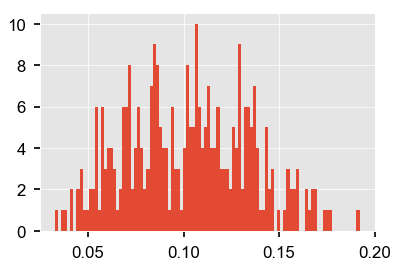

In [151]:
plt.hist(times_512_omp12, bins=100)

In [133]:
np.min(times_512_omp12), np.std(times_512_omp12), np.mean(times_512_omp12)

(0.032744205032940954, 0.032393582621711305, 0.10216643648532529)

In [127]:
times_512_omp10 = np.array([0.020103697024751455, 0.015386254992336035, 0.015342398022767156, 0.015335000003688037, 0.015328043955378234, 0.01533902803203091, 0.015347669017501175, 0.01535412500379607, 0.015344371960964054, 0.015365795989055187, 0.015366429986897856, 0.015334993950091302, 0.015373932023067027, 0.015353220980614424, 0.015365632018074393, 0.01534628204535693, 0.01538306096335873, 0.015358867007307708, 0.015370617969892919, 0.01535553898429498, 0.015401713957544416, 0.015363720012828708, 0.015353462018538266, 0.015355131006799638, 0.015352190006524324, 0.015359124983660877, 0.015345701947808266, 0.015351114969234914, 0.0153638010378927, 0.01533088501309976, 0.015326555003412068, 0.01535501703619957, 0.015348184038884938, 0.015395140973851085, 0.015333785966504365, 0.015341088990680873, 0.01569824799662456, 0.015484052011743188, 0.015366156992968172, 0.015364866005256772, 0.015386419952847064, 0.01540794299216941, 0.015370948996860534, 0.015367394022177905, 0.015375705028418452, 0.015371474029961973, 0.01537874701898545, 0.015415854984894395, 0.015340069017838687, 0.015342728001996875, 0.015375807008240372, 0.01535988599061966, 0.015343295992352068, 0.0153644880047068, 0.015402490040287375, 0.015365038008894771, 0.015362349979113787, 0.015368718944955617, 0.015368659980595112, 0.015372466994449496, 0.01540199900045991, 0.015339703008066863, 0.01535176602192223, 0.015361041005235165, 0.015379173040855676, 0.015354975999798626, 0.015377714997157454, 0.01538661599624902, 0.015357721014879644, 0.015328031033277512, 0.015347570995800197, 0.015356153016909957, 0.01537499000551179, 0.015410302963573486, 0.015346606029197574, 0.01534304500091821, 0.015362448990345001, 0.01535400003194809, 0.015329214977100492, 0.0153393599903211, 0.015431315987370908, 0.015363219019491225, 0.015379695978481323, 0.015387277991976589, 0.01536140195094049, 0.015392959001474082, 0.015410511987283826, 0.01536247500916943, 0.015354981005657464, 0.015370300970971584, 0.0153912179521285, 0.015347505977842957, 0.015381169971078634, 0.015407986007630825, 0.015372531954199076, 0.015347560052759945, 0.015363037004135549, 0.01535857398994267, 0.015384698985144496, 0.015417212038300931, 0.015345531981438398, 0.01535037497524172, 0.015456583991181105, 0.015370293986052275, 0.015368186985142529, 0.015388393017929047, 0.015401778975501657, 0.015373246977105737, 0.015331781993154436, 0.015342893020715564, 0.01535535795846954, 0.015350716013927013, 0.015407724014949054, 0.01535016397247091, 0.015329559973906726, 0.015370601962786168, 0.01535676495404914, 0.0153648040140979, 0.015390711952932179, 0.0154028789838776, 0.015460454975254834, 0.01544241001829505, 0.015384140016976744, 0.015390983026009053, 0.015363676007837057, 0.01541497401194647, 0.015344106999691576, 0.015363613027147949, 0.01534065802115947, 0.01537391496822238, 0.015605265973135829, 0.015617249009665102, 0.01563829998485744, 0.0156514749978669, 0.015614595031365752, 0.015624666993971914, 0.01562860800186172, 0.015658057003747672, 0.015686064027249813, 0.0156275539775379, 0.015637335018254817, 0.015642017999198288, 0.015634256007615477, 0.01569508999818936, 0.015648073982447386, 0.015631480957381427, 0.01562512305099517, 0.015639062970876694, 0.015616888995282352, 0.015634359035175294, 0.01562574499985203, 0.01567299198359251, 0.015618873992934823, 0.015625319036189467, 0.015630333975423127, 0.015660863020457327, 0.015680740994866937, 0.015693072986323386, 0.01562616799492389, 0.015637224016245455, 0.015628357999958098, 0.01560355699621141, 0.01566492795245722, 0.015639460005331784, 0.015666344028431922, 0.015637703996617347, 0.0156339019886218, 0.015698236995376647, 0.015640293015167117, 0.015669382992200553, 0.015674048976507038, 0.015645952022168785, 0.015633051982149482, 0.01562643301440403, 0.015634077019058168, 0.015627141983713955, 0.015698136994615197, 0.0156536620343104, 0.015638026990927756, 0.015633780043572187, 0.015638321987353265, 0.015623409999534488, 0.015675832983106375, 0.015671639994252473, 0.015641264035366476, 0.015624071995262057, 0.01562864298466593, 0.01562669494887814, 0.015642116020899266, 0.015682408004067838, 0.015649306995328516, 0.015636112017091364, 0.015661985031329095, 0.01564793399302289, 0.01566855696728453, 0.01562942797318101, 0.015634862997103482, 0.015618145000189543, 0.015641363977920264, 0.01562630501575768, 0.01564802398206666, 0.015637668024282902, 0.01566579897189513, 0.015630759007763118, 0.015612420975230634, 0.015631882997695357, 0.01563320297282189, 0.015678980969823897, 0.015697657014243305, 0.0156868519843556, 0.01564747898373753, 0.015638848999515176, 0.015619117999449372, 0.015366424981039017, 0.015380322991404682, 0.015362010046374053, 0.015615971991792321, 0.015327737026382238, 0.015332626004237682, 0.015345407999120653, 0.01537370402365923, 0.01536714198300615, 0.01531899196561426, 0.015324226988013834, 0.015321168000809848, 0.015323876985348761, 0.015334850992076099, 0.01536145800491795, 0.015382098034024239, 0.01533823600038886, 0.01532111200504005, 0.015420217998325825, 0.01533530600136146, 0.015377575997263193, 0.015394747955724597, 0.015653987997211516, 0.015338095952756703, 0.015334535972215235, 0.01531778700882569, 0.015331881993915886, 0.015431969019118696, 0.015399949043057859, 0.01533581898547709, 0.01531975099351257, 0.015347520005889237, 0.015337953984271735, 0.015381270030047745, 0.015410650987178087, 0.01533895096508786, 0.015328363981097937, 0.01540022500557825, 0.015349266992416233, 0.015356319956481457, 0.015350539004430175, 0.015434986969921738, 0.015328796987887472, 0.015319016994908452, 0.01532016898272559, 0.01536544697592035, 0.015521129011176527, 0.015534111007582396, 0.01549692201660946, 0.015482283954042941, 0.015456662978976965, 0.015506816969718784, 0.015476803004276007, 0.015959161974024028, 0.015558265033178031, 0.015471789985895157, 0.015521274995990098, 0.015488601988181472, 0.015487225959077477, 0.015522390021942556, 0.015550277021247894, 0.015496737032663077, 0.015483847993891686, 0.015456884982995689, 0.015351473004557192, 0.015347415988799185, 0.015328173991292715, 0.015620683028828353, 0.015346258005592972, 0.015347117034252733, 0.015342026017606258, 0.015347411972470582, 0.01537045300938189, 0.015417597023770213, 0.015351331967394799, 0.015347906039096415, 0.015357989992480725, 0.015380728000309318, 0.015337970980908722, 0.015340320009272546, 0.015338108001742512, 0.015335701988078654, 0.015356186020653695, 0.015425624966155738, 0.015346885018516332, 0.015367530984804034, 0.015395103022456169])

(array([ 117.,   64.,   14.,   10.,    5.,    2.,   61.,   25.,    0.,
           0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([ 0.01531779,  0.01536565,  0.01541351,  0.01546136,  0.01550922,
         0.01555708,  0.01560494,  0.0156528 ,  0.01570066,  0.01574852,
         0.01579638,  0.01584424,  0.0158921 ,  0.01593996,  0.0

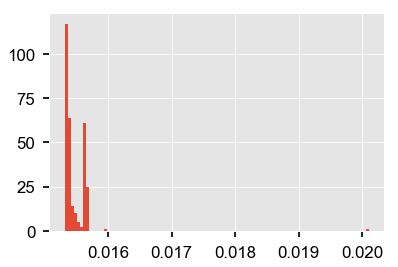

In [129]:
plt.hist(times_512_omp10, bins=100)